In [1]:
import math
import numpy as np
import scipy
from scipy import integrate
from scipy.stats import norm
from mpl_toolkits import mplot3d
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

arctan = np.arctan
cos = np.cos
det = np.linalg.det
exp = np.exp
inner = np.inner
log = np.log
matmul = np.matmul
norm = np.linalg.norm
odeint = integrate.odeint
pi = np.pi
quad = integrate.quad
randbinom = np.random.binomial
randexp = np.random.exponential
randnorm = np.random.normal
randperm = np.random.permutation
randuni = np.random.uniform
sin = np.sin
sqrt = np.sqrt

In [2]:
covid_df =pd.read_csv("/content/COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths_20240630.csv")
retained_columns = ["CASE_COUNT", "PROBABLE_CASE_COUNT", "HOSPITALIZED_COUNT", "DEATH_COUNT"]
covid_df = covid_df[retained_columns]

In [36]:
class epidemic():

  def __init__(self, guess_gamma, guess_repro_rate, guess_phi, guess_infected, guess_susceptible, gamma_stdv, repro_rate_stdv, phi_stdv, i_0_stdv, s_0_stdv, population, mcmc_lookback, hospitalizations, max_days, freq):

    self.day = 0
    self.population = population
    self.hospitalizations = hospitalizations #real world data we will use
    self.max_days = max_days
    self.mcmc_lookback = mcmc_lookback
    self.freq = freq



    self.gamma_intervals = [(guess_gamma, guess_gamma)]
    self.repro_rate_intervals = [(guess_repro_rate, guess_repro_rate)]
    self.phi_intervals = [(guess_phi, guess_phi)]
    self.i_intervals = [(guess_infected/population, guess_infected/population)]
    self.s_intervals = [(guess_susceptible/population, guess_susceptible/population)]
    self.guess_s_0 = guess_susceptible/self.population
    self.guess_i_0 = guess_infected/self.population
    self.peak_time_intervals = [(0, 0)]
    self.gamma_stdv = gamma_stdv
    self.repro_rate_stdv = repro_rate_stdv
    self.phi_stdv = phi_stdv
    self.i_0_stdv = i_0_stdv
    self.s_0_stdv = s_0_stdv
    self.last_run = 0


  def norm_pdf(self, mean, var, x):


    return 1/math.sqrt(2*math.pi*var)*math.exp(((x-mean)**2)/(-2*var))


  def repro_rate_prior(self, x):
    return self.norm_pdf((self.repro_rate_intervals[-1][0]+self.repro_rate_intervals[-1][1])/2, self.repro_rate_stdv**2, x) #normal prior centered at middle of our last confidence interval

  def gamma_prior(self, x):
    #return 1
    return self.norm_pdf((self.gamma_intervals[-1][0]+self.gamma_intervals[-1][1])/2, self.gamma_stdv**2, x)  #normal prior centered at middle of our last confidence interval

  def phi_prior(self, x):
    #return 1
    return self.norm_pdf((self.phi_intervals[-1][0]+self.phi_intervals[-1][1])/2, self.phi_stdv**2, x)  #normal prior centered at middle of our last confidence interval

  def s_0_prior(self, x): #uniform prior. We dont know anything about this
    return 1

  def i_0_prior(self, x):
    return 1





  def integrate_from_initial_conditions(self, initial, days, repro_rate, gamma):

    #function purpose: given an initial (susceptible, infected) and our (gamma, rho) SIR parameters, tell us future path of the disease over some number of days

    #initial: initial (susceptible, infected)
    #days: how long to run the simulation
    #beta: beta parameter for SIR
    #gamma: gamma parameter SIR

    def change_vector(x,t,beta,gamma):                      #tell us the instantaneous change in our (susceptible, infected) population
      return [-beta*x[0]*x[1], beta*x[0]*x[1]-(gamma)*x[1]]   #dynamics of the SIR model



    initial = np.reshape(initial, 2)  #reshaping for the odeint function
    beta = repro_rate*gamma

    steps = days
    T = np.linspace(0,steps,days)     #numpy array which contains the times at which we want to know our (susceptible, infected) value


    path = odeint(change_vector, initial, T, args=(beta,gamma))   #integrate from our initial values according to SIR dynamics


    s = path[:,0]   #get the susceptible array
    i = path[:, 1]  #get the infected array

    return s, i

  def log_likelihood(self, hospitalization_data, initial, repro_rate, gamma, phi): #calculate log posterior of our hospitalization data given parameters, initial condition, priors, etc


    s, i = self.integrate_from_initial_conditions(initial, len(hospitalization_data), repro_rate, gamma) #get the susceptible, infected curves which you would expect with these parameters

    for infected in i:
      if infected <= 0:
        return -math.inf

    current_likelihood = 0



    for f in range((len(hospitalization_data))):
      expected_new_hospitalized = self.population*i[f]*phi*gamma

      pdf = self.norm_pdf(expected_new_hospitalized, expected_new_hospitalized*(1-phi*gamma), hospitalization_data[f])
      if pdf<=0:
        return -math.inf
      current_likelihood +=math.log(pdf)


    return (current_likelihood+math.log(self.repro_rate_prior(repro_rate))+math.log(self.gamma_prior(gamma))+math.log(self.phi_prior(phi))+math.log(self.s_0_prior(initial[0]))+math.log(self.i_0_prior(initial[1]))) #add logs of our priors on the params)



  def debug_log_likelihood(self, hospitalization_data, initial, repro_rate, gamma, phi): #ignore


    s, i = self.integrate_from_initial_conditions(initial, len(hospitalization_data), repro_rate, gamma) #get the susceptible, infected curves which you would expect with these parameters

    expected_new_hospitalized = []
    for f in range((len(hospitalization_data))):
      expected_new_hospitalized.append(self.population*i[f]*phi*gamma)

    plt.clf()
    print("Should be plotting rn")
    plt.plot(np.array(range(len(hospitalization_data))).reshape(-1), np.array(expected_new_hospitalized).reshape(-1), label = "my stupid curve")
    plt.plot(np.array(range(len(hospitalization_data))).reshape(-1), np.array(hospitalization_data).reshape(-1), label = "the right data")
    plt.legend(loc = "upper left")
    plt.show()
    print("\n Initial: ", initial)
    print("\n Gamma: ", gamma)
    print("\n Phi: ", phi)
    print("\n Repro rate: ", repro_rate)

    for infected in i:
      if infected <= 0:
        return -math.inf

    current_likelihood = 0



    for f in range((len(hospitalization_data))):
      expected_new_hospitalized = self.population*i[f]*phi*gamma

      pdf = self.norm_pdf(expected_new_hospitalized, expected_new_hospitalized*(1-phi*gamma), hospitalization_data[f])
      if pdf<=0:
        return -math.inf
      current_likelihood +=math.log(pdf)






    return (current_likelihood+math.log(self.repro_rate_prior(repro_rate))+math.log(self.gamma_prior(gamma))+math.log(self.phi_prior(phi))+math.log(self.s_0_prior(initial[0]))+math.log(self.i_0_prior(initial[1])))

  def mcmc(self, data, iterations): #metropolis hastings algorithm to explore posterior distribution

    def repro_rate_proposal_distribution(current):     #generate new proposed parameters from normal distributions centered at our current parameters
      return max(np.random.normal(current, self.repro_rate_stdv/12), 0.0001)

    def gamma_proposal_distribution(current):
      return max(np.random.normal(current, self.gamma_stdv/12), 0.0001)

    def phi_proposal_distribution(current):
      return max(np.random.normal(current, self.phi_stdv/12), 0.00001)

    def s_i_proposal_distribution(s_0_current, i_0_current): #generate new initial conditions (s_0, i_0). Use a stdv that is proportional to our current initial conditions

      s_0_proposal = max(min(0.999, s_0_current*np.random.normal(1, self.s_0_stdv)), 0.001)
      i_0_proposal = max(min(1-s_0_proposal-0.001, i_0_current*np.random.normal(1, self.i_0_stdv)), 0.0001)

      return s_0_proposal, i_0_proposal



    s_0_accepted = []
    i_0_accepted = []
    repro_rate_accepted = []
    gamma_accepted = []
    phi_accepted = []


    repro_rate_current = (self.repro_rate_intervals[-1][0]+self.repro_rate_intervals[-1][1])/2    #initialize to guess values
    gamma_current = (self.gamma_intervals[-1][0]+self.gamma_intervals[-1][1])/2
    phi_current = (self.phi_intervals[-1][0]+self.phi_intervals[-1][1])/2
    s_0_current = self.guess_s_0
    i_0_current = self.guess_i_0


    current_likelihood  = self.log_likelihood(data, (s_0_current, i_0_current), repro_rate_current, gamma_current, phi_current) #log posterior


    if current_likelihood <= -math.inf:
      i_0_current = data[0]/(self.population*gamma_current*phi_current)
      current_likelihood = self.log_likelihood(data, (s_0_current, i_0_current), repro_rate_current, gamma_current, phi_current)

    while current_likelihood <= -math.inf: #just getting off the ground. If the posterior is -infty, iterate until you find something finite
      k = 0
      s_0_current = np.random.uniform(0.001, 1-i_0_current-0.001)

      current_likelihood = self.log_likelihood(data, (s_0_current, i_0_current), repro_rate_current, gamma_current, phi_current)
      k = k+1

    accepted=[]


    for k in range(iterations):

      repro_rate_proposed = repro_rate_proposal_distribution(repro_rate_current)
      gamma_proposed = gamma_proposal_distribution(gamma_current)
      phi_proposed = phi_proposal_distribution(phi_current)
      s_0_proposed, i_0_proposed = s_i_proposal_distribution(s_0_current, i_0_current)

      proposed_likelihood = self.log_likelihood(data, (s_0_proposed, i_0_proposed), repro_rate_proposed, gamma_proposed, phi_proposed) #calculate log likelihood of new parameters
      x = random.uniform(0, 1)


      if proposed_likelihood>current_likelihood or x < math.exp(proposed_likelihood-current_likelihood): #if we are moving to a higher probability density region -> accept; or, if we are moving to a lower density region but likelihood ratio exceeds random x -> accept

        repro_rate_current = repro_rate_proposed
        gamma_current = gamma_proposed
        phi_current = phi_proposed
        s_0_current = s_0_proposed
        i_0_current = i_0_proposed

        current_likelihood = proposed_likelihood
        s_0_accepted.append(s_0_current)
        i_0_accepted.append(i_0_current)
        repro_rate_accepted.append(repro_rate_current)
        gamma_accepted.append(gamma_current)
        phi_accepted.append(phi_current)








      #if k>0 and k%3000 ==0:
        #print(k)
        #print("\n Current params: \n")
        #print(s_0_current, i_0_current, repro_rate_current, gamma_current, phi_current)
        #print("\n Proposed params")
        #print(s_0_proposed, i_0_proposed, repro_rate_proposed, gamma_proposed, phi_proposed)
        #print("\n Current likelihood: "+str(current_likelihood))
        #print("\n Proposed likelihood: "+str(proposed_likelihood))
        #print("\n Acceptance rate: "+str(len(s_0_accepted)/k))

    return s_0_accepted[math.floor(len(s_0_accepted)/4):], i_0_accepted[math.floor(len(i_0_accepted)/4):], repro_rate_accepted[math.floor(len(repro_rate_accepted)/4):], gamma_accepted[math.floor(len(gamma_accepted)/4):], phi_accepted[math.floor(len(phi_accepted)/4):] #return the array of accepted params, shave off burn in


  def hpd(self, samples):  #find 95% hpd interval for a variable given list of samples

    samples.sort()
    window = math.floor(0.95*len(samples))
    min = 100000000
    upper_bound = 0
    lower_bound = 0
    k = 0
    while(k+window < len(samples)): #range over all windows that contain 95% of the samples

      present_width = samples[k+window]-samples[k]  #current width
      if present_width<min:    #if we find a narrower window with 95% of samples
        min = present_width
        upper_bound = samples[k+window]  #new upper and lower bounds for the 95% interval
        lower_bound = samples[k]
      k = k+1

    return lower_bound, upper_bound



  def project_s_i(self, s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted, target_index): #produce 95% hpd interval for (s, i) pair given array of (s_0, i_0, repro_rate, gamma, phi) proposals generated by mcmc

    projected_s_0 = []
    projected_i_0 = []

    for i in range(int(len(s_0_accepted)/10)): #this for loop looks at each (s_0, i_0, repro_rate, gamma, phi) tuple, calculates the forward (s, i) value, and adds to our return arrays

      index = np.random.randint(0, len(s_0_accepted))
      s_0 = s_0_accepted[index]
      i_0 = i_0_accepted[index]
      repro_rate = repro_rate_accepted[index]
      gamma = gamma_accepted[index]
      phi = phi_accepted[index]

      initial = (s_0, i_0)

      s, i = self.integrate_from_initial_conditions(initial, target_index, repro_rate, gamma)

      projected_s_0.append((s[-1]))
      projected_i_0.append((i[-1]))


    return projected_s_0, projected_i_0

  def project_path(self, s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted): #produce 95% confidence interval for the peak time and 95% intervals for the path of the infected population

    infected_path_data = []
    infected_path_upper = []
    infected_path_mean = []
    infected_path_lower = []

    peak_times = []






    for j in range(int(len(s_0_accepted)/10)): #sample from our accepted values

      index = np.random.randint(0, len(s_0_accepted))
      s_0 = s_0_accepted[index]
      i_0 = i_0_accepted[index]
      repro_rate = repro_rate_accepted[index]
      gamma = gamma_accepted[index]
      phi = phi_accepted[index]



      initial = (s_0, i_0)

      s, i = self.integrate_from_initial_conditions(initial, 100, repro_rate, gamma)


      peak_times.append(self.day-self.mcmc_lookback+np.argmax(i))
      infected_path_data.append(i[0:100])





    infected_path_data = np.transpose(np.array(infected_path_data))


    for k in range(100):


      infected_point_hpd = self.hpd(infected_path_data[k])
      infected_path_upper.append(infected_point_hpd[1])
      infected_path_lower.append(infected_point_hpd[0])
      infected_path_mean.append(np.mean(infected_path_data[k]))

    infected_path_upper = np.array(infected_path_upper)*self.population
    infected_path_lower = np.array(infected_path_lower)*self.population
    infected_path_mean = np.array(infected_path_mean)*self.population

    peak_hpd = self.hpd(peak_times)
    peak_upper = peak_hpd[1]
    peak_lower = peak_hpd[0]

    return peak_upper, peak_lower, infected_path_upper, infected_path_lower, infected_path_mean




  def update(self):

    if self.day<self.mcmc_lookback:
      print("Day: "+str(self.day)+", not enough data to begin simulation\n")
      self.day = self.day +1
      self.last_run = self.last_run+1
      return
    if self.hospitalizations[self.day-self.mcmc_lookback]==0:
      print("Day: "+str(self.day)+", not enough data to begin simulation\n")
      self.day = self.day +1
      self.last_run = self.last_run+1
      return

    if (self.day-self.last_run)%self.freq != 0: #only update once every freq days

      self.day = self.day +1
      return





    s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted = self.mcmc(self.hospitalizations[(self.day-self.mcmc_lookback):self.day], 400000) #mcmc step






    self.repro_rate_stdv = np.std(repro_rate_accepted)
    self.gamma_stdv = np.std(gamma_accepted)
    self.phi_stdv = np.std(phi_accepted)
    self.repro_rate_intervals.append(self.hpd(repro_rate_accepted.copy()))
    self.gamma_intervals.append(self.hpd(gamma_accepted.copy()))
    self.phi_intervals.append(self.hpd(phi_accepted.copy()))

    current_s, current_i = self.project_s_i(s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted, self.mcmc_lookback)
    self.s_intervals.append(self.hpd(current_s))
    self.i_intervals.append(self.hpd(current_i))


    peak_upper, peak_lower, infected_path_upper, infected_path_lower, infected_path_mean= self.project_path(s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted)
    self.peak_time_intervals.append((peak_lower, peak_upper))

    #self.s_0_stdv = np.std(projected_s_0)
    #self.i_0_stdv = np.std(projected_i_0)



    next_guess_s_0, next_guess_i_0 = self.project_s_i(s_0_accepted, i_0_accepted, repro_rate_accepted, gamma_accepted, phi_accepted, self.freq)
    self.guess_s_0 = np.mean(next_guess_s_0)
    self.guess_i_0 = np.mean(next_guess_i_0)


    print("Day: ", str(self.day) + "\n")
    #print("Fraction of proposals accepted: ", str(len(s_0_accepted)*1.33/250000) + "\n")
    print("Rho 95% confidence interval: ", str(self.repro_rate_intervals[-1]) + "\n")
    print("Gamma 95% confidence interval: ", str(self.gamma_intervals[-1]) + "\n")
    print("Phi 95% confidence interval: ", str(self.phi_intervals[-1]) + "\n")
    print("Currently susceptible 95% confidence interval: ", str(self.s_intervals[-1]) + "\n")
    print("Currently infected 95% confidence interval: ", str(self.i_intervals[-1]) + "\n")
    print("Peak time 95% confidence interval: ", str(self.peak_time_intervals[-1]) + "\n")


    plt.clf()
    plt.plot(range(self.day-self.mcmc_lookback, self.day-self.mcmc_lookback+len(infected_path_mean)), infected_path_mean, label = "total infected path mean")
    plt.plot(range(self.day-self.mcmc_lookback, self.day-self.mcmc_lookback+len(infected_path_mean)), infected_path_upper, label = "total infected path 95% upper")
    plt.plot(range(self.day-self.mcmc_lookback, self.day-self.mcmc_lookback+len(infected_path_mean)), infected_path_lower, label = "total infected path 95% lower")
    plt.title("Projected total infected population by date")
    plt.xlabel("Day")
    plt.ylabel("Infected population, millions")
    plt.legend(loc="upper right")
    plt.show()



    self.last_run = self.day
    self.day = self.day + 1

    return

  def run_simulation(self):




    k = 0
    while(k<self.max_days):
      self.update()
      k = k+1

    return

In [37]:
covid = epidemic(guess_gamma = 0.1, guess_repro_rate = 4, guess_phi = 0.03, guess_infected = 10000, guess_susceptible = 7500000, gamma_stdv = 0.02, repro_rate_stdv= 1, phi_stdv = 0.01, i_0_stdv = 0.0025, s_0_stdv = 0.0025, population = 8500000, mcmc_lookback = 15, hospitalizations=covid_df["HOSPITALIZED_COUNT"].values.tolist(), max_days = 40, freq = 5)

Day: 0, not enough data to begin simulation

Day: 1, not enough data to begin simulation

Day: 2, not enough data to begin simulation

Day: 3, not enough data to begin simulation

Day: 4, not enough data to begin simulation

Day: 5, not enough data to begin simulation

Day: 6, not enough data to begin simulation

Day: 7, not enough data to begin simulation

Day: 8, not enough data to begin simulation

Day: 9, not enough data to begin simulation

Day: 10, not enough data to begin simulation

Day: 11, not enough data to begin simulation

Day: 12, not enough data to begin simulation

Day: 13, not enough data to begin simulation

Day: 14, not enough data to begin simulation

Day:  15

Rho 95% confidence interval:  (3.8702414846875177, 6.163137934013911)

Gamma 95% confidence interval:  (0.07209865312159222, 0.13041685764333383)

Phi 95% confidence interval:  (0.0016874670168110233, 0.024366772781754913)

Currently susceptible 95% confidence interval:  (0.6935607885532244, 0.981219402792092

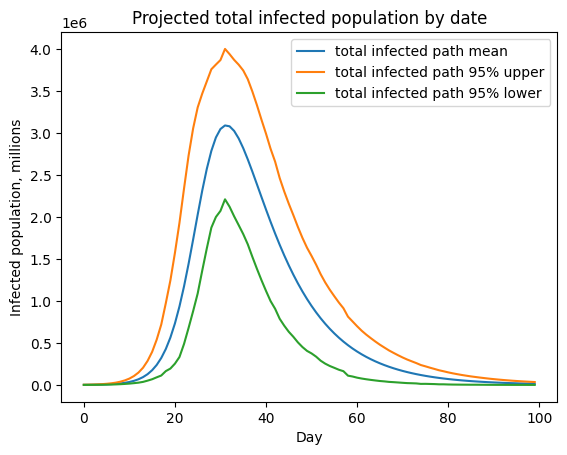

Day:  20

Rho 95% confidence interval:  (3.87350318673155, 6.540238499237025)

Gamma 95% confidence interval:  (0.09218648741698929, 0.13854388094285855)

Phi 95% confidence interval:  (0.009197529761098165, 0.026171006493816915)

Currently susceptible 95% confidence interval:  (0.408123540405653, 0.8182697516580668)

Currently infected 95% confidence interval:  (0.025539269366231028, 0.06110775829779945)

Peak time 95% confidence interval:  (30, 36)



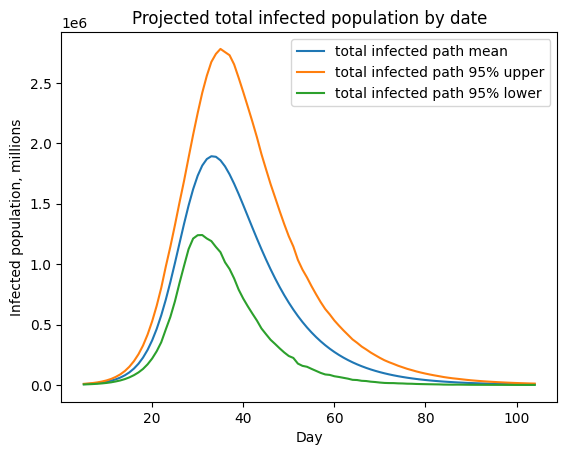

Day:  25

Rho 95% confidence interval:  (4.818168047034456, 7.413258956064948)

Gamma 95% confidence interval:  (0.09793079265069707, 0.1434933251192325)

Phi 95% confidence interval:  (0.007507720923105082, 0.015285889148050798)

Currently susceptible 95% confidence interval:  (0.23425211655176395, 0.39142712067554486)

Currently infected 95% confidence interval:  (0.07497902161289068, 0.16730991821361874)

Peak time 95% confidence interval:  (30, 33)



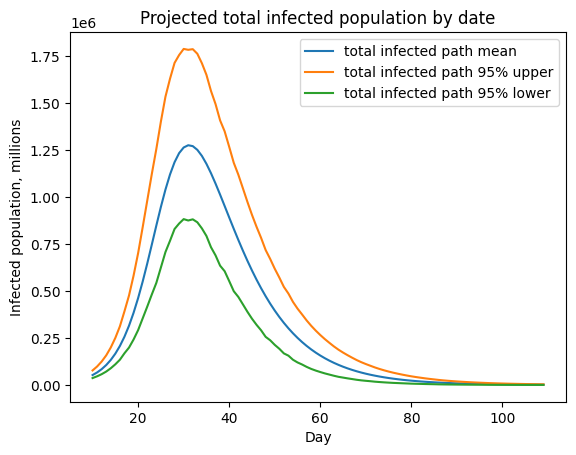

Day:  30

Rho 95% confidence interval:  (5.21781382546869, 7.663976860732274)

Gamma 95% confidence interval:  (0.09121591082273373, 0.1468488661964053)

Phi 95% confidence interval:  (0.007361369263949516, 0.012840915558216091)

Currently susceptible 95% confidence interval:  (0.121411539915484, 0.1869514614099927)

Currently infected 95% confidence interval:  (0.09971525825864624, 0.2455254629313028)

Peak time 95% confidence interval:  (29, 30)



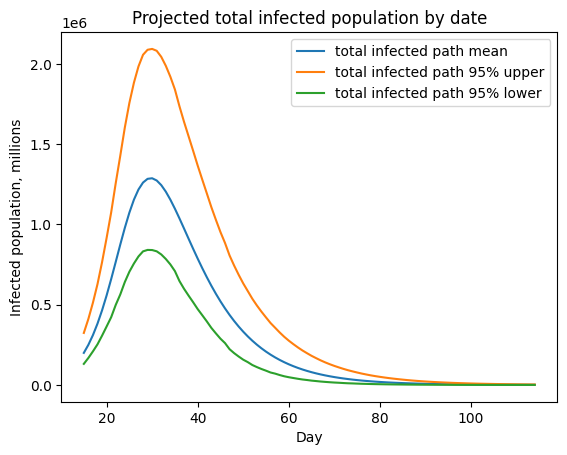

Day:  35

Rho 95% confidence interval:  (4.979551747702792, 6.911771165885486)

Gamma 95% confidence interval:  (0.08107754734380831, 0.1262027043103629)

Phi 95% confidence interval:  (0.010130980096621183, 0.013332775864370015)

Currently susceptible 95% confidence interval:  (0.09659565596408996, 0.15035132162941825)

Currently infected 95% confidence interval:  (0.11933626965310445, 0.21436621735786496)

Peak time 95% confidence interval:  (31, 32)



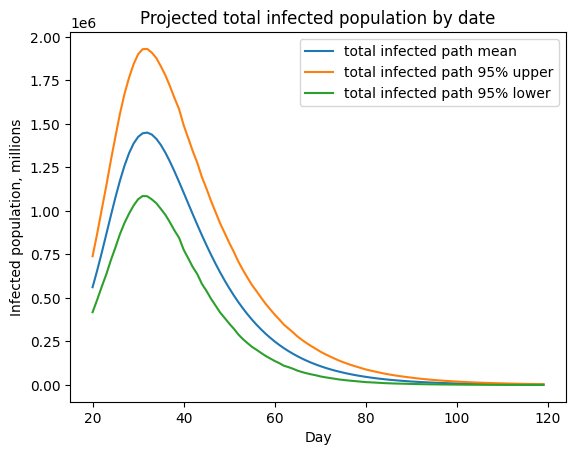

In [38]:
covid.run_simulation()

In [ ]:
 def log_likelihood(hospitalization_data, initial, repro_rate, gamma, phi, population): #calculate log likelihood of our infection data given parameters, initial condition, and estimate of noise variance


    s, i = self.integrate_from_initial_conditions(initial, len(hospitalization_data), repro_rate, gamma, phi) #get the susceptible, infected curves which you would expect with these parameters

    for infected in i:
      if infected <= 0:
        return 0

    current_likelihood = 0



    for f in range((len(hospitalization_data))):
      expected_new_hospitalized = population*i[f]*phi*gamma
      pdf = self.norm_pdf(expected_new_hospitalized, (expected_new_hospitalized**2)*self.noise_sigma2, hospitalization_data[f])
      if pdf<=0:
        return -math.inf
      current_likelihood +=math.log(pdf)


    return (current_likelihood+math.log(self.repro_rate_prior(repro_rate))+math.log(self.gamma_prior(gamma))+math.log(self.phi_prior(phi))+math.log(self.s_0_prior(initial[0]))+math.log(self.i_0_prior(initial[1])))


1.4153438522946606


In [ ]:
#covid.log_likelihood(covid.hospitalizations[10:25], (0.355, 0.004553373099860541), 8.559896206424003, 0.12674959554591247, 0.012731347183414272, 8500000)
print(np.argmax(covid_df["HOSPITALIZED_COUNT"].values.tolist()))

30
